# "Quantizing a Deep Learning Model"
> "Quantization is one of the most popular techniques when compressing a Neural Network. This codelab shows how to perform Post Training Quantization with PyTorch. It is based on one of the codelabs from the Efficient Deep Learning book, which uses TensorFlow. If you are more confortable using PyTorch, now you have no excuse, let's quantize🐜!"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [quantization, efficient_deeplearning]
- image: images/pixelart_quant.jpg

![](https://raw.githubusercontent.com/XanaGA/posts_en/6d6f32ecc94946e193b900fbe0f0f6c99cfcf14c/images/pixelart_quant.jpg)

# Introduction

As the description says introduced, this is a version of a [codelab](https://github.com/EfficientDL/book/blob/main/codelabs/Chapter-02-Compression-Techniques/Quantizing-A-Deep-Learning-Model.ipynb) from the "[Efficient Deep Learning](https://efficientdlbook.com/)" book. The book uses TensorFlow so I thought it would be a good idea to try to implement the same ideas with PyTorch.


So we will try to make things as similar as possible to the original notebook in case anyone wants to use it to follow the book. I will try not to repeat the explanations made in that notebook and focuse on explaining the changes regarding the PyTorch implementation. 

Moreover, there is a [post](https://xanaga.github.io/posts_en/quantization/efficient_deeplearning/2022/05/30/Improving_quantization_by_normalizing_weights.html) that explores some difficulties we found while doing the PyTorch implementation, so you may be interested into reading it as well.

# Collecting the Dataset

In [4]:
import numpy as np
import time
import os
import torch
import torchvision
from torch import nn, optim
from torchsummary import summary
from tqdm.notebook import tqdm
import torch.utils.data as data_utils

def process_x(x):
  """Process the given tensors of images."""
  x = x.type(torch.float32) 

  # The original data is in [0.0, 255.0].
  # This normalization helps in making them lie between [-1.0, 1.0].
  x /= 127.5
  x -= 1.0

  # Now we have [NxWxH], add one dimension for the channels 
  # We add it to dim 1 because Pytorch image format is [CxWxH]
  x = torch.unsqueeze(x, dim=1)
  return x

def load_data(ds=torchvision.datasets.MNIST):
  """Returns the processed dataset."""
  training, test = ds('./data/mnist', download=True), ds('./data/mnist', download=True, train=False)
  train_images, train_labels = process_x(training.data), training.targets
  test_images, test_labels = process_x(test.data), test.targets
  
  return (train_images, train_labels), (test_images, test_labels)


(train_x, train_y), (test_x, test_y) = load_data()

0.1%

100.0%


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



102.8%


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



10.4%

100.0%


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



112.7%

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



We will have to specify which device we want to use:

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Visualize the dataset

The part of visualising the dataset will be the same as in the original notebook.

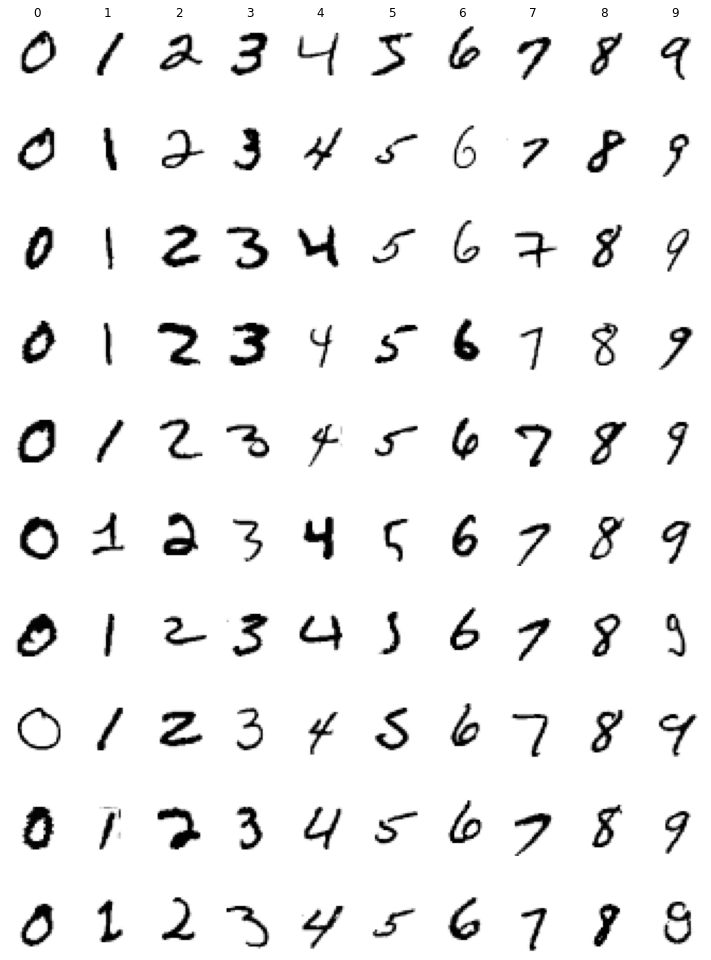

In [ ]:
# collapse-show

%matplotlib inline
import matplotlib.pyplot as plt

def collect_samples(x, y, num_classes=10, num_per_class=5):
  sampled_x = None
  sampled_x_idx = 0
  for class_idx in range(num_classes):
    num_collected = 0
    for idx in range(len(x)):
      if num_collected == num_per_class:
        break

      if y[idx] != class_idx:
        continue

      if sampled_x is not None:
        sampled_x = np.concatenate((sampled_x, np.expand_dims(x[idx], 0)))
      else:
        sampled_x = np.expand_dims(x[idx], 0)
      sampled_x_idx = sampled_x_idx + 1
      num_collected = num_collected + 1

  return sampled_x

def show_images(images, num_rows = 1, titles = None):
    """Display a list of images in a single figure with matplotlib. """
    # assert((titles is None)or (len(images) == len(titles)))
    num_images = len(images)
    num_cols = num_images // num_rows

    # plot images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.25 * num_rows, 1.75 * num_cols))
    
    for i in range(num_images):
      ax = axes[i%num_cols, i//num_cols]
      ax.axis('off')
      ax.imshow(np.squeeze(images[i]), cmap='Greys')
      # ax.add_axes((0, 0, 1, 1))
      if i % num_cols == 0:
        ax.set_title('{}'.format(int(i / num_rows)))
    # plt.tight_layout()
    plt.show()
  
show_images(collect_samples(train_x, train_y, num_per_class=10), num_rows=10)

For creating the model we will use a class. Using `Sequential()` would be more similar to how it is done with Keras, but I think using the class will allow for more flexibility. 

You will see a `norm_w` argument passed to the constructor. It is used for normalizing the weights of the layers, as it improves significantly the effectivity of the quantization. This is further detailed in the [complementary post](https://xanaga.github.io/posts_en/quantization/efficient_deeplearning/2022/05/30/Improving_quantization_by_normalizing_weights.html).

In [ ]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.0, norm_w=True):
        super(CNN, self).__init__()

        self.norm_w = norm_w

        # Create the layers normalizing or not the weigths
        if self.norm_w:
            self.conv_layer1 = nn.utils.weight_norm(nn.Conv2d(in_channels=1, out_channels=32, 
                                     kernel_size=3), name='weight')
            self.conv_layer2 = nn.utils.weight_norm(nn.Conv2d(32, 64, 3), name='weight')
            self.fc = nn.utils.weight_norm(nn.Linear(in_features= 64*5*5, out_features=10), name='weight')
          
        else:
            self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, 
                                     kernel_size=3)
            self.conv_layer2 = nn.Conv2d(32, 64, 3)
            self.fc = nn.Linear(in_features= 64*5*5, out_features=10)

        
        # input dimensions are Bx1x28x28 (BxCxHxW)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.batch_norm2 = nn.BatchNorm2d(64)

        self.flat = nn.Flatten()
        self.drop = nn.Dropout(p=dropout_rate)


    def forward(self, x):
        # Block 1
        out = self.conv_layer1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 2
        out = self.conv_layer2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.pool(out)

        # Flatten the output using BxC*H*W 
        out = self.flat(out)
        out = self.drop(out)
        out = self.fc(out)
        
        return out

    def add_quant(self):
        '''
        Returns a new model with added quantization layers
        '''
        return nn.Sequential(torch.quantization.QuantStub(), self,
                          torch.quantization.DeQuantStub())

In [ ]:
# Check the model 
toy_model = CNN()
summary(toy_model, input_size=(1,28,28),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
              ReLU-7           [-1, 64, 11, 11]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
           Flatten-9                 [-1, 1600]               0
          Dropout-10                 [-1, 1600]               0
           Linear-11                   [-1, 10]          16,010
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

**Quick Notes:**



*   The BatchNorm2d in PyTorch appears as it has half of the parameters than the Keras one. This is because Keras count the **accumulated means** and **accumulated std** as non-trainable parameters, while Pytorch simply hide them. So PyTorch only counts as Batch Normalization parmeters the **scale** and the **offset**. This also explains the difference in the 192 non-trainable parameters.
*   Forward/backward pass size (MB) refears to the expected memory to run the model.



# Training without PyTorch Model Quantization

As PyTorch does not have a training loop using `.fit()` like Keras does, we will have to implement our own. It is not a plain PyTorch traiining loop as we will print some metrics and save them for the later plots.

> `Note: This could be done in fewer lines of code using Fastai or PyTorch Lightning, and for tracking is better to use platforms such as Weights & Biases. But as is not the point of this post we will continue as it is.`

In [ ]:
def train_model(model, epochs, bz=128, device='cuda'):
  # Save the model training information
  model_history = {"loss":[], "sparse_categorical_accuracy": [],
                   "val_loss":[], "val_sparse_categorical_accuracy":[]}

  # Show the model summary
  model.to(device)
  summary(model, input_size=(1,28,28), device=device)

  # Define the training hyperparameters
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()

  # Create the training and validation dataloders
  train = data_utils.TensorDataset(train_x, train_y)
  train_loader = data_utils.DataLoader(train, batch_size=bz, shuffle=True)

  val = data_utils.TensorDataset(test_x, test_y)
  val_loader = data_utils.DataLoader(val, batch_size=bz, shuffle=False)

  for epoch in range(epochs):  # loop over the number of epochs

    start = time.time()
    print(f'Epoch {epoch+1}')
    train_loss = 0.0
    train_correct = 0.0

    val_loss = 0.0
    val_correct = 0.0

    # Loop over the trainig set
    for data in tqdm(train_loader):

        # Move the data to the corresponding device
        x, y = data
        x, y = x.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += outputs.shape[0] * loss.item()
        train_correct += (outputs.argmax(1) == y).detach().cpu().sum()
    
    # Log the training loss and metrics
    train_loss = train_loss/float(len(train_x))
    train_correct = train_correct/float(len(train_x))

    model_history["loss"].append(train_loss)
    model_history["sparse_categorical_accuracy"].append(train_correct)

    #Loop over the validation set:
    model.eval()
    with torch.inference_mode():

      for data in val_loader:
          x, y = data
          x, y = x.to(device), y.to(device)

          outputs = model(x)
          loss = criterion(outputs, y)

          val_loss += outputs.shape[0] * loss.item()
          val_correct += (outputs.argmax(1) == y).detach().cpu().sum()

    # Log the training loss and metrics
    val_loss = val_loss/float(len(test_x))
    val_correct = val_correct/float(len(test_x))

    model_history["val_loss"].append(val_loss)
    model_history["val_sparse_categorical_accuracy"].append(val_correct)

    model.train()

    end = time.time()

    # Print information for the epoch
    print(f"Time: {(end-start):.2f} s  - ",
          f"Loss: {train_loss:.4f}  -  Categorical_Accuracy: {train_correct:.4f}  - ",
          f"Val_Loss: {val_loss:.4f}  -  Categorical_Val_Accuracy: {val_correct:.4f}")

  print('Finished Training')

  return model, model_history

In [ ]:
no_quant = CNN()
basic_mnist_model, basic_mnist_model_history = train_model(no_quant, epochs=15, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
              ReLU-7           [-1, 64, 11, 11]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
           Flatten-9                 [-1, 1600]               0
          Dropout-10                 [-1, 1600]               0
           Linear-11                   [-1, 10]          16,010
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.67 s  -  Loss: 0.1699  -  Categorical_Accuracy: 0.9557  -  Val_Loss: 0.0609  -  Categorical_Val_Accuracy: 0.9810
Epoch 2


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.54 s  -  Loss: 0.0498  -  Categorical_Accuracy: 0.9845  -  Val_Loss: 0.0487  -  Categorical_Val_Accuracy: 0.9865
Epoch 3


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.56 s  -  Loss: 0.0388  -  Categorical_Accuracy: 0.9876  -  Val_Loss: 0.0431  -  Categorical_Val_Accuracy: 0.9877
Epoch 4


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.55 s  -  Loss: 0.0300  -  Categorical_Accuracy: 0.9909  -  Val_Loss: 0.0472  -  Categorical_Val_Accuracy: 0.9855
Epoch 5


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.57 s  -  Loss: 0.0245  -  Categorical_Accuracy: 0.9925  -  Val_Loss: 0.0317  -  Categorical_Val_Accuracy: 0.9903
Epoch 6


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.55 s  -  Loss: 0.0226  -  Categorical_Accuracy: 0.9930  -  Val_Loss: 0.0365  -  Categorical_Val_Accuracy: 0.9879
Epoch 7


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.52 s  -  Loss: 0.0186  -  Categorical_Accuracy: 0.9943  -  Val_Loss: 0.0333  -  Categorical_Val_Accuracy: 0.9891
Epoch 8


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.52 s  -  Loss: 0.0165  -  Categorical_Accuracy: 0.9949  -  Val_Loss: 0.0339  -  Categorical_Val_Accuracy: 0.9899
Epoch 9


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.55 s  -  Loss: 0.0143  -  Categorical_Accuracy: 0.9952  -  Val_Loss: 0.0352  -  Categorical_Val_Accuracy: 0.9893
Epoch 10


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.55 s  -  Loss: 0.0122  -  Categorical_Accuracy: 0.9964  -  Val_Loss: 0.0273  -  Categorical_Val_Accuracy: 0.9915
Epoch 11


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.62 s  -  Loss: 0.0109  -  Categorical_Accuracy: 0.9964  -  Val_Loss: 0.0298  -  Categorical_Val_Accuracy: 0.9908
Epoch 12


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.54 s  -  Loss: 0.0089  -  Categorical_Accuracy: 0.9971  -  Val_Loss: 0.0278  -  Categorical_Val_Accuracy: 0.9919
Epoch 13


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.69 s  -  Loss: 0.0082  -  Categorical_Accuracy: 0.9973  -  Val_Loss: 0.0365  -  Categorical_Val_Accuracy: 0.9893
Epoch 14


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 5.18 s  -  Loss: 0.0082  -  Categorical_Accuracy: 0.9972  -  Val_Loss: 0.0389  -  Categorical_Val_Accuracy: 0.9889
Epoch 15


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 5.89 s  -  Loss: 0.0075  -  Categorical_Accuracy: 0.9975  -  Val_Loss: 0.0309  -  Categorical_Val_Accuracy: 0.9915
Finished Training


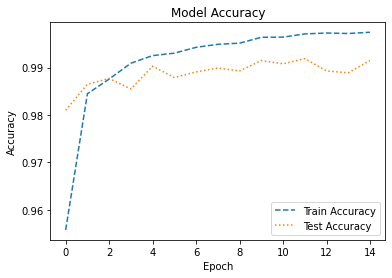

In [ ]:
plt.plot(
    basic_mnist_model_history['sparse_categorical_accuracy'], 
    linestyle='dashed')
plt.plot(
    basic_mnist_model_history['val_sparse_categorical_accuracy'], 
    linestyle='dotted')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.show()

# Helper functions for Pytorch Quantizantion and evaluation

These two functions will compute the **size** of our model. As it is mentioned in the book, it is an important metric to take into account when evaluanting models (not just the score).

> `Note: We won't use the first one, it is just informative, you can use it for non-quantized models. It is an aproximation and will be a bit lower than the real size.`

In [ ]:
def model_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
      
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  model_size = (param_size + buffer_size) / 1024

def real_model_size(model):
  torch.save(model.state_dict(), "temp.p")
  size = os.path.getsize("temp.p")/1024
  os.remove('temp.p')
  return size

The following evaluation functions use the same logic as the ones presented in the book. 

In [ ]:
def pytorch_model_eval(model, test_images, test_labels, quantized):
  """Evaluate the generated model."""

  num_correct = 0
  num_total = 0

  model.eval()

  with torch.inference_mode():
    for idx in range(len(test_images)):
      num_total = num_total + 1

      if quantized:
          input = test_images[idx:idx+1].to("cpu")
      else:
          input = test_images[idx:idx+1].to(device)
          
      
      output = model(input)

      # The returned output is a tensor of logits, so we find the maximum in that 
      # tensor, and see if it matches the label.
      if output.argmax(1) == test_labels[idx]:
        num_correct = num_correct + 1
  
  print('Accuracy:', num_correct * 1.0 / num_total)

The `quantize_and_eval` function includes the code needed for quantizing the model, which is inspired in the official PyTorch [post](https://pytorch.org/blog/quantization-in-practice/) which I recommend reading.

To do so we do the following steps:

* If present, remove weight normalization from the layers as is not supported in quantization.

* Change the model to the **CPU** and put it into **evaluation** mode. 

* Set the **backend** to `fbgemm` to run the model on a computer with x86 architecture. If we want the model to run on mobile devices which normally have arm architecture, you need to use `qnnpack` for the backend.

* **Fuse**: this consist in converting a list of modules into a single module. The output will be the same, but PyTorch will optimize some operations for us. This will save memory and make the model run faster. But it is optional and not all layers are supported. In our case we will fuse our two convolutional blocks, *conv+batch_norm+(relu)*. You can read more about fusion and which layers can be fused [here](https://pytorch.org/tutorials/recipes/fuse.html).

* Add the **stubs layers** at the beginning and the end of the 
model. Those will be converted after **calibration** to quantize the inputs and outputs.

* Set the **configuration**, we will use the default.

* **Calibrate**: We take a sample of the training data that represents the data on which we will evaluate,  to teach the model how to quantize the inputs and activations. Although, here we are using directly the test data so it could be considered a bit like *cheating*. But as is not the point of the notebook we will leave it as it is and keep that in mind for real-world applications.

* **Convert**: where the actual quantization is made.

In [ ]:
# Create the directory for storing PyTorch models.
! mkdir -p 'pytorch_models'

def quantize_and_eval(model, model_name, quantized_export, test_dataset_x, 
                     test_dataset_y):
  """Helper method to eval a model (quantizing it or not)."""

  # Remove the normalization from the weighted layers as is not suported in quantization
  if model.norm_w:
    for m in model.modules():
      if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.utils.remove_weight_norm(m)

  if quantized_export:
    
    # Some operations not suported on GPU
    model.to("cpu")
    model.eval()

    # Backend for using a serever
    backend = "fbgemm"

    """Fuse
    - Inplace fusion replaces the first module in the sequence with the fused module, and the rest with identity modules
    """
    torch.quantization.fuse_modules(model, [['conv_layer1','batch_norm1','relu'], 
                                            ['conv_layer2', 'batch_norm2']], inplace=True)

    """Insert stubs"""
    model = model.add_quant()

    """Prepare"""
    model.qconfig = torch.quantization.get_default_qconfig(backend)
    torch.quantization.prepare(model, inplace=True)

    """Calibrate"""
    with torch.inference_mode():
      for idx in range(min(len(test_dataset_x), 1000)):
        x = test_dataset_x[idx:idx+1].to("cpu")
        model(x)
        
    """Convert"""
    torch.quantization.convert(model, inplace=True)

  model_name = '{}_{}.pt'.format(
      model_name, ('quantized' if quantized_export else 'float'))
  
  print('Model Name: {}, Quantized: {}'.format(model_name, quantized_export))
  print('Model Size: {:.2f} KB'.format(real_model_size(model)))
  torch.save(model.state_dict(), os.path.join('pytorch_models', model_name))
  
  # Evaluate the model.
  start = time.time()
  pytorch_model_eval(model, test_dataset_x, test_dataset_y, 
                    quantized_export)
  end = time.time()
  print('Eval time: {:.2f}s'.format(end-start))

# Chain everything together in a single train function

Now we only need to put all the pieces together!🎉🎉

In [6]:
import os
import numpy as np
from copy import deepcopy

def train_model_and_quantize(batch_size=128, epochs=100, model_name='mnist_model', norm_w=True):
  model = CNN(norm_w=norm_w).to(device)

  model, model_history = train_model(model, epochs, bz=batch_size)

  print("Running Final Evaluation")

  # Convert and evaluate both (floating point and quantized models).
  q_model = deepcopy(model)
  quantize_and_eval(model, model_name, False, test_x, test_y)
  quantize_and_eval(q_model, model_name, True, test_x, test_y)

  return model, model_history

In [ ]:
mnist_model, mnist_model_history = train_model_and_quantize(epochs=15)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
              ReLU-7           [-1, 64, 11, 11]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
           Flatten-9                 [-1, 1600]               0
          Dropout-10                 [-1, 1600]               0
           Linear-11                   [-1, 10]          16,010
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.73 s  -  Loss: 0.1884  -  Categorical_Accuracy: 0.9522  -  Val_Loss: 0.0486  -  Categorical_Val_Accuracy: 0.9840
Epoch 2


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.57 s  -  Loss: 0.0508  -  Categorical_Accuracy: 0.9849  -  Val_Loss: 0.0457  -  Categorical_Val_Accuracy: 0.9854
Epoch 3


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.63 s  -  Loss: 0.0391  -  Categorical_Accuracy: 0.9880  -  Val_Loss: 0.0392  -  Categorical_Val_Accuracy: 0.9858
Epoch 4


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.63 s  -  Loss: 0.0321  -  Categorical_Accuracy: 0.9898  -  Val_Loss: 0.0359  -  Categorical_Val_Accuracy: 0.9885
Epoch 5


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.61 s  -  Loss: 0.0276  -  Categorical_Accuracy: 0.9915  -  Val_Loss: 0.0286  -  Categorical_Val_Accuracy: 0.9912
Epoch 6


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.65 s  -  Loss: 0.0224  -  Categorical_Accuracy: 0.9936  -  Val_Loss: 0.0275  -  Categorical_Val_Accuracy: 0.9912
Epoch 7


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.64 s  -  Loss: 0.0200  -  Categorical_Accuracy: 0.9938  -  Val_Loss: 0.0337  -  Categorical_Val_Accuracy: 0.9899
Epoch 8


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.69 s  -  Loss: 0.0171  -  Categorical_Accuracy: 0.9945  -  Val_Loss: 0.0331  -  Categorical_Val_Accuracy: 0.9883
Epoch 9


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.69 s  -  Loss: 0.0153  -  Categorical_Accuracy: 0.9951  -  Val_Loss: 0.0272  -  Categorical_Val_Accuracy: 0.9911
Epoch 10


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.60 s  -  Loss: 0.0149  -  Categorical_Accuracy: 0.9951  -  Val_Loss: 0.0310  -  Categorical_Val_Accuracy: 0.9901
Epoch 11


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.61 s  -  Loss: 0.0128  -  Categorical_Accuracy: 0.9958  -  Val_Loss: 0.0267  -  Categorical_Val_Accuracy: 0.9916
Epoch 12


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.61 s  -  Loss: 0.0094  -  Categorical_Accuracy: 0.9971  -  Val_Loss: 0.0315  -  Categorical_Val_Accuracy: 0.9904
Epoch 13


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.60 s  -  Loss: 0.0086  -  Categorical_Accuracy: 0.9975  -  Val_Loss: 0.0277  -  Categorical_Val_Accuracy: 0.9910
Epoch 14


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.62 s  -  Loss: 0.0081  -  Categorical_Accuracy: 0.9974  -  Val_Loss: 0.0358  -  Categorical_Val_Accuracy: 0.9899
Epoch 15


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 4.63 s  -  Loss: 0.0081  -  Categorical_Accuracy: 0.9973  -  Val_Loss: 0.0318  -  Categorical_Val_Accuracy: 0.9906
Finished Training
Running Final Evaluation
Model Name: mnist_model_float.pt, Quantized: False
Model Size: 142.11 KB
Accuracy: 0.9906
Eval time: 7.14s


/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:179: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


Model Name: mnist_model_quantized.pt, Quantized: True
Model Size: 41.67 KB
Accuracy: 0.9845
Eval time: 8.91s


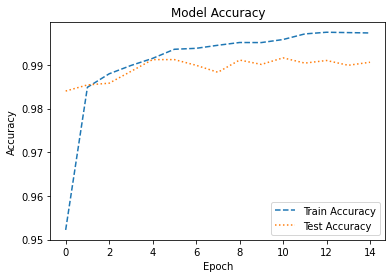

In [ ]:
plt.plot(
    mnist_model_history['sparse_categorical_accuracy'], 
    linestyle='dashed')
plt.plot(
    mnist_model_history['val_sparse_categorical_accuracy'], 
    linestyle='dotted')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.show()